In [1]:
import os
import pandas as pd
import glob
import numpy as np
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

### 1. 모델링을 위한 데이터 불러오기

In [2]:
# base_dir = 'val_24h_median.csv'
base_dir = 'val_24hr_median_df_0628.csv'
val = pd.read_csv(base_dir, low_memory=False)
# base_dir = 'test_24h_median.csv'
base_dir = 'test_24hr_median_df_0628.csv'
test = pd.read_csv(base_dir, low_memory=False)

In [3]:
# 위도, 경도 칼럼 제거
val = val.drop(columns=[col for col in val.columns if 'longitude' in col or 'latitude' in col])
test = test.drop(columns=[col for col in test.columns if 'longitude' in col or 'latitude' in col])

#### 1-1. 다중공선성 확인 및 변수 제거

Columns to drop due to high correlation: ['HRV_IQRNN', 'HRV_MadNN', 'HRV_MaxNN', 'HRV_MeanNN', 'HRV_MedianNN', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_RMSSD', 'HRV_SDANN1', 'HRV_SDANN2', 'HRV_SDANN5', 'HRV_SDNN', 'HRV_SDNNI1', 'HRV_SDNNI2', 'HRV_SDNNI5', 'HRV_SDSD', 'HRV_pNN20', 'HRV_pNN50', 'altitude_max', 'altitude_mean', 'altitude_median', 'altitude_min', 'distance', 'heart_rate_max', 'heart_rate_mean', 'heart_rate_median', 'heart_rate_min', 'speed', 'speed_mean', 'speed_median', 'speed_min', 'step_frequency', 'steps', 'walking_steps', 'x_mean', 'x_median', 'y_mean', 'y_median', 'z_max', 'z_mean', 'z_median', 'z_min']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HRV_CVNN              105 non-null    float64
 1   HRV_CVSD              105 non-null    float64
 2   HRV_HTI               105 non-null    float64
 3   HRV_MCVNN  

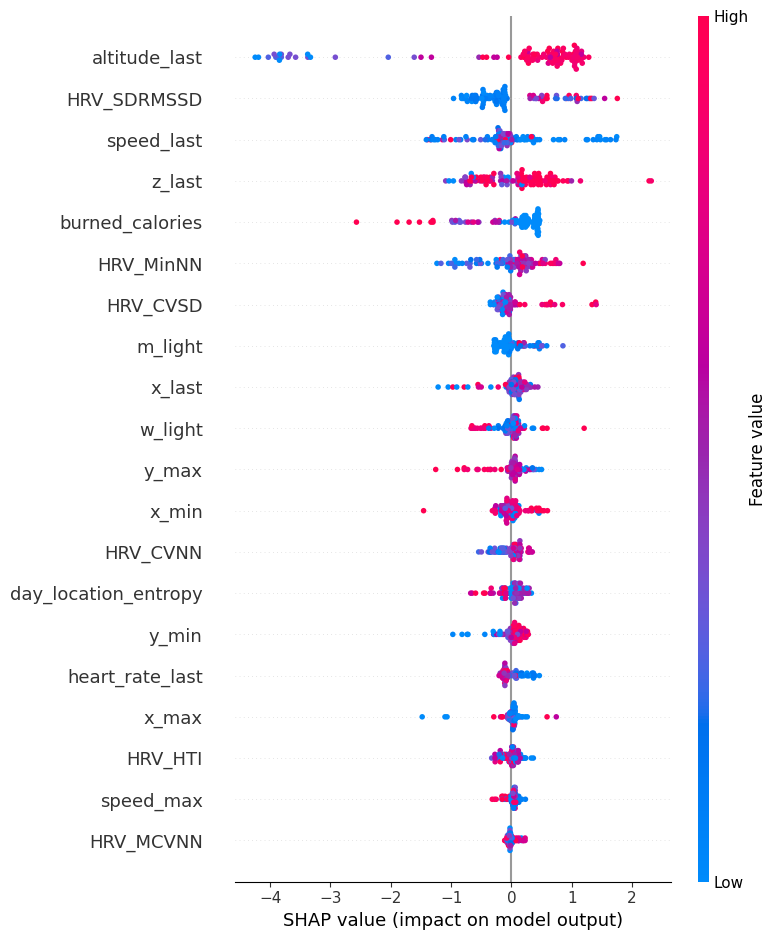

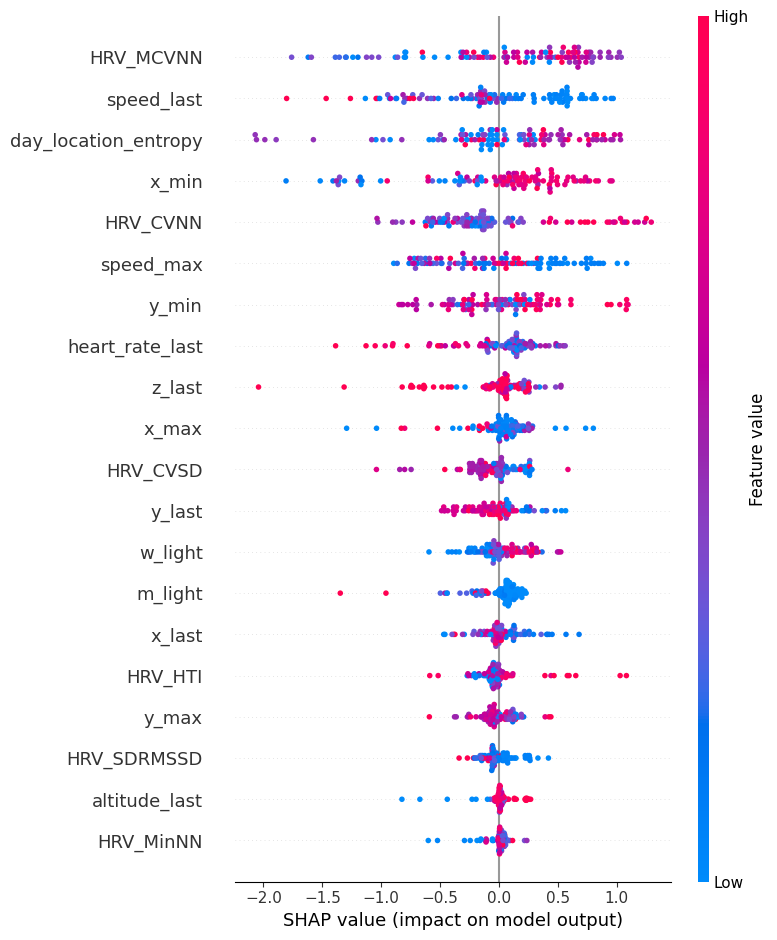

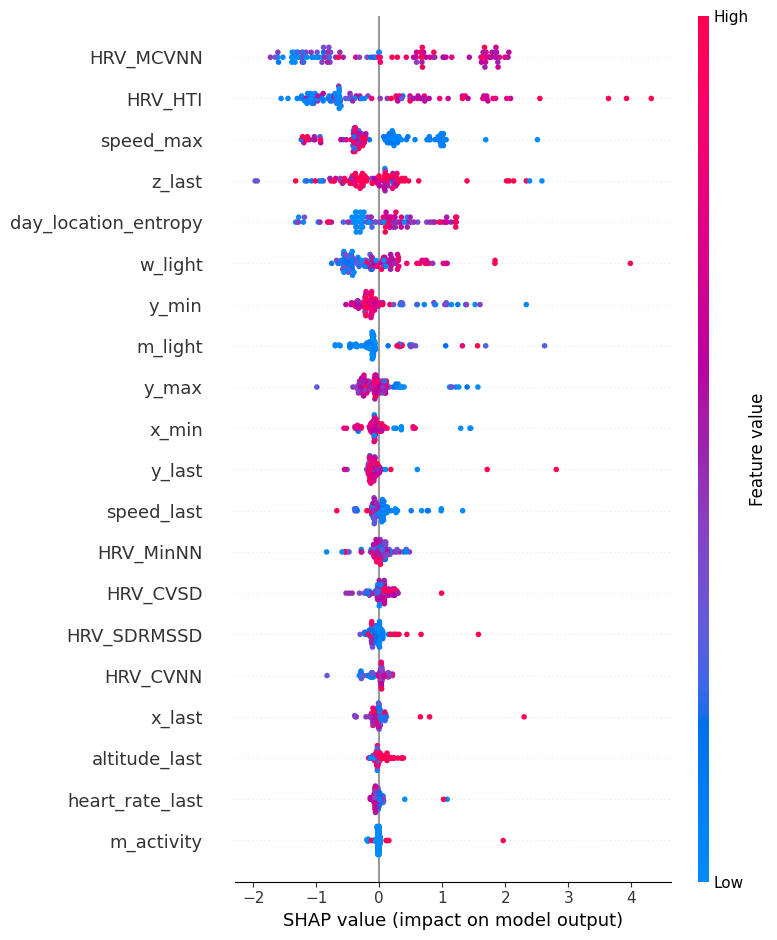

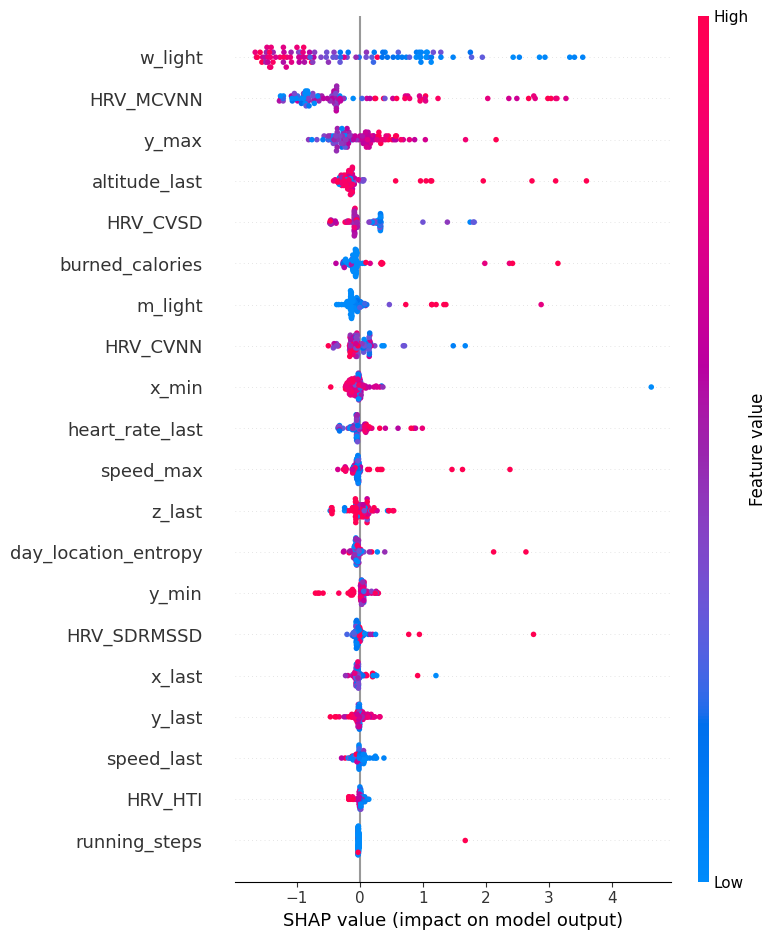

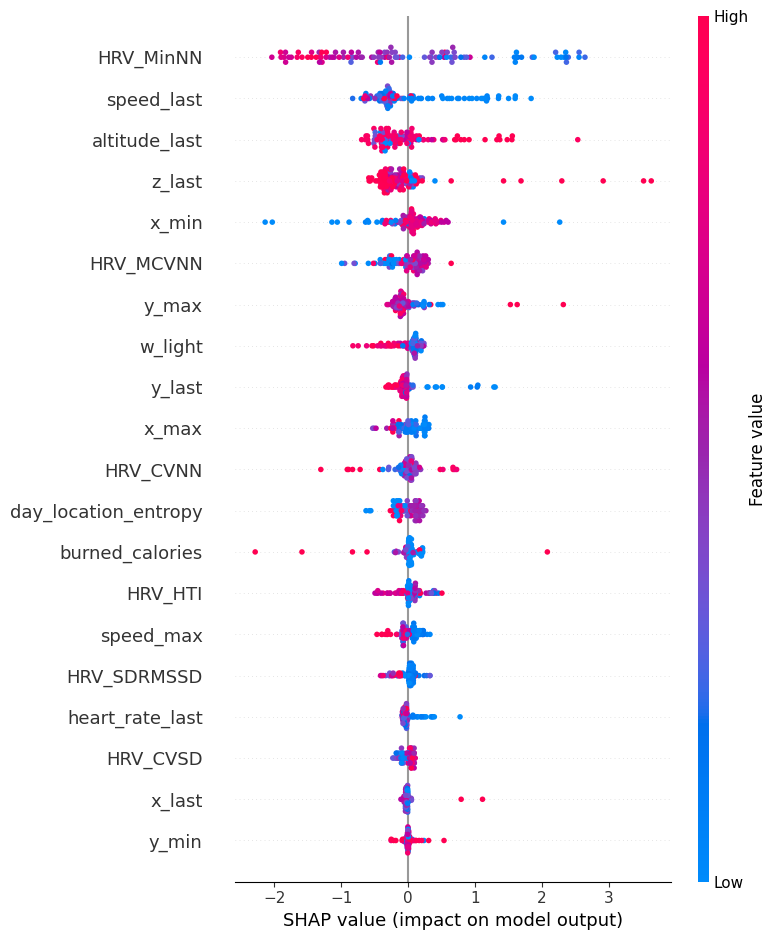

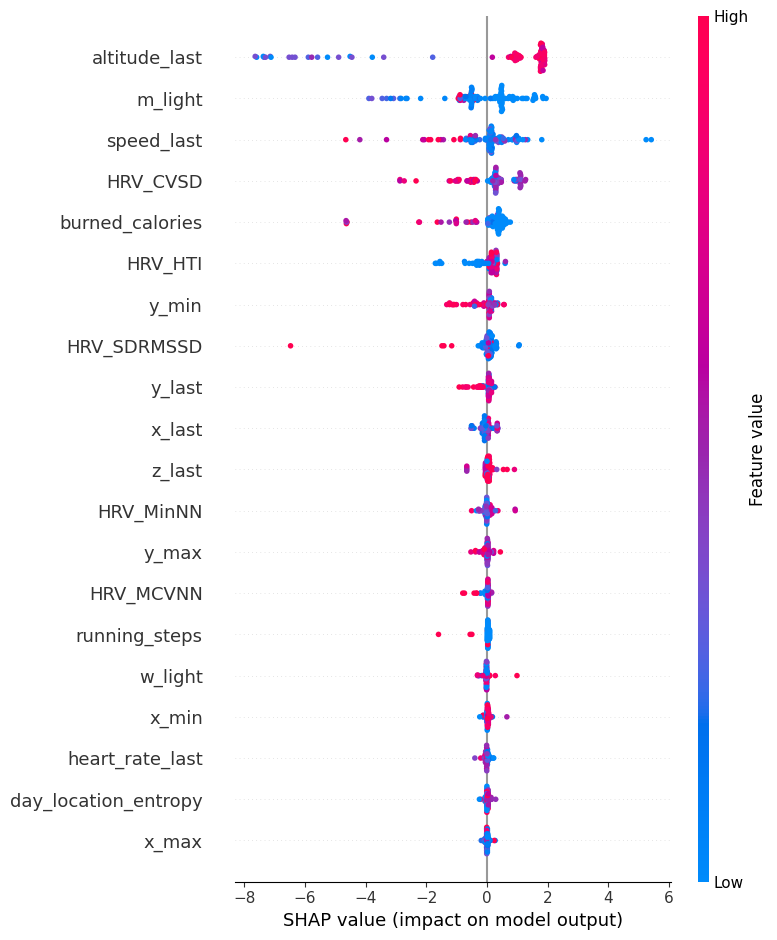

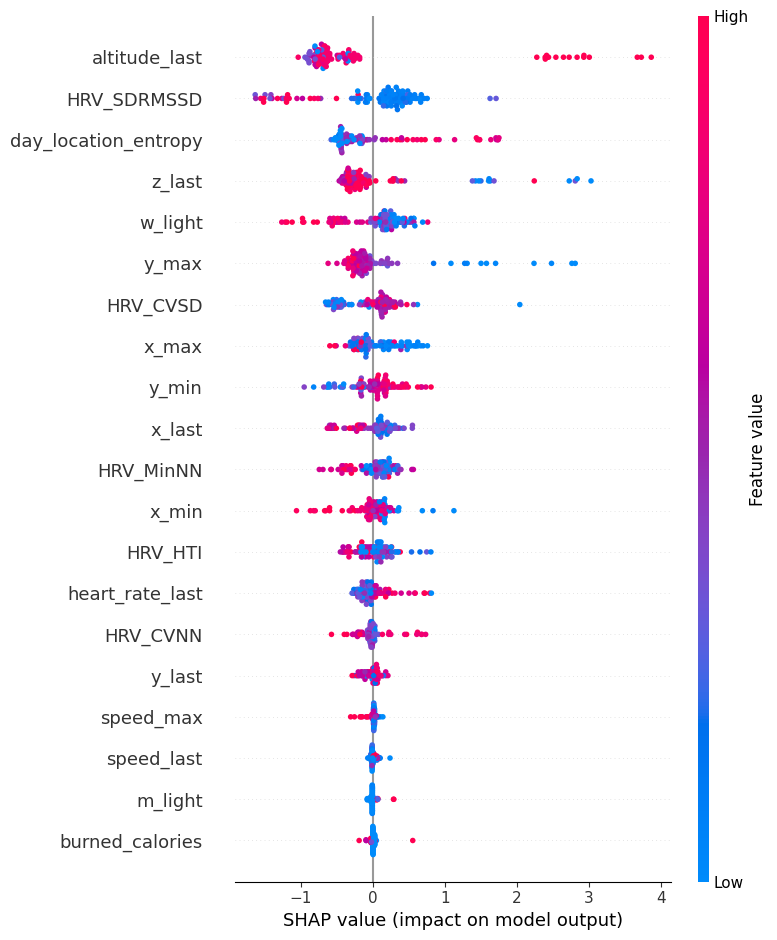

In [4]:
targets = ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3', 'S4']
features_to_drop = ['datetime', 'user'] + targets  # targets는 이전에 정의한 예측할 타겟 변수 목록

X = val.drop(columns=features_to_drop)
y = val[targets]

# 상관계수 계산
corr_matrix = X.corr().abs()

# 상위 삼각 행렬 얻기
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# 상관계수 기준으로 변수 제거 (threshold=0.8)
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

print("Columns to drop due to high correlation:", to_drop)

# 다중공선성이 높은 변수 제거
X_reduced = X.drop(columns=to_drop)

# 상관계수와 다중공선성 제거 후 데이터프레임 정보 출력
print(X_reduced.info())

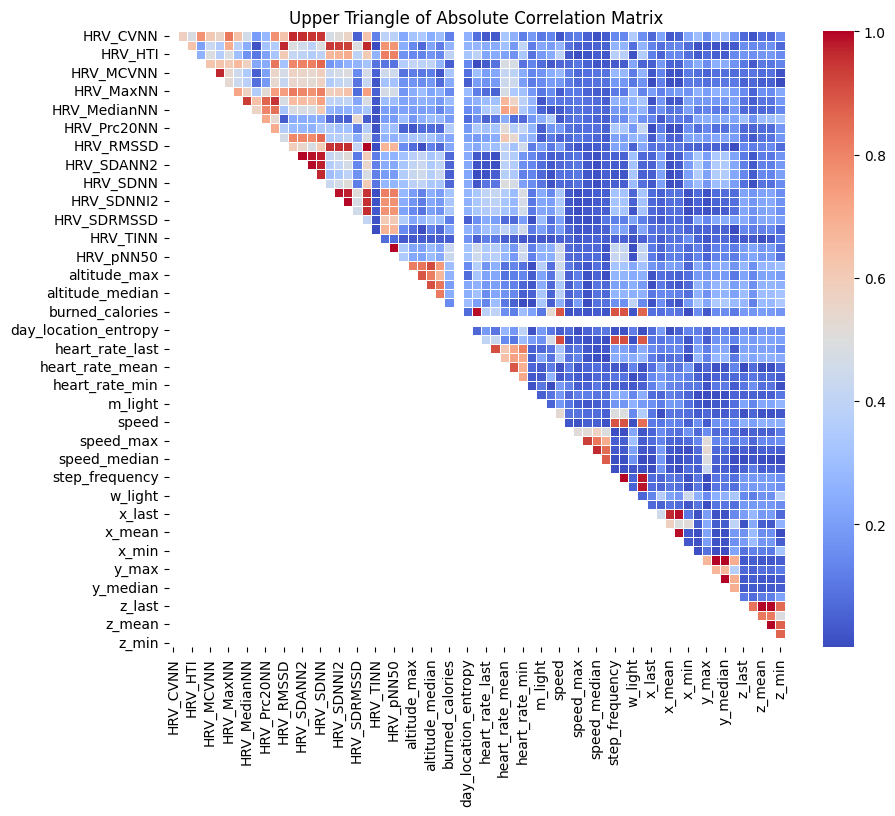

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 상위 삼각 행렬 시각화 및 저장
plt.figure(figsize=(10, 8))
sns.heatmap(upper, cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title('Upper Triangle of Absolute Correlation Matrix')
plt.savefig('upper_triangle_correlation_matrix.png')
plt.show()

In [9]:
# metrics 딕셔너리 초기화
metrics = {
    'accuracy': {},
    'f1_score': {},
    'precision': {},
    'recall': {},
    'auc': {}
}

models = {}
predictions = {}

# 파라미터 그리드
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 데이터 분할 및 훈련
for target in targets:
    X = X_reduced
    y = val[target]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Data scaling
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # SMOTE for oversampling
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    # Model training
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_val_scaled)
    y_prob = best_model.predict_proba(X_val_scaled)[:, 1]  # Probability values
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_val, y_pred, average='macro')
    auc = roc_auc_score(y_val, y_prob)
    
    metrics['accuracy'][target] = accuracy
    metrics['f1_score'][target] = f1
    metrics['precision'][target] = precision
    metrics['recall'][target] = recall    
    metrics['auc'][target] = auc
    
    print(f'Performance metrics for {target}:')
    print(f'  Accuracy: {accuracy}')
    print(f'  F1-score (macro): {f1}')
    print(f'  Precision: {precision}')
    print(f'  Recall: {recall}')
    print(f'  AUC: {auc}')
    
    models[target] = best_model
    predictions[target] = y_pred

# Model and prediction results as DataFrame
pred_df = pd.DataFrame(predictions)
metrics_df = pd.DataFrame(metrics)

print(pred_df)
print(metrics_df)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Performance metrics for Q1:
  Accuracy: 0.7619047619047619
  F1-score (macro): 0.7407407407407407
  Precision: 0.7355769230769231
  Recall: 0.75
  AUC: 0.8061224489795918
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Performance metrics for Q2:
  Accuracy: 0.6190476190476191
  F1-score (macro): 0.475
  Precision: 0.5
  Recall: 0.5
  AUC: 0.6224489795918368
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Performance metrics for Q3:
  Accuracy: 0.5714285714285714
  F1-score (macro): 0.5333333333333333
  Precision: 0.5336538461538461
  Recall: 0.5357142857142857
  AUC: 0.7040816326530612
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Performance metrics for S1:
  Accuracy: 0.5714285714285714
  F1-score (macro): 0.4457478005865103
  Precision: 0.44999999999999996
  Recall: 0.44375
  AUC: 0.4375
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Performance metrics for 

In [ ]:
def xgboost_model(X_reduced, val, targets, param_grid):
    metrics = {
        'accuracy': {},
        'f1_score': {},
        'precision': {},
        'recall': {},
        'auc': {}
    }
    models = {}
    predictions = {}

    # Data splitting and model training
    for target in targets:
        X = X_reduced
        y = val[target]
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Data scaling
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
        
        # Model training
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        
        best_model = grid_search.best_estimator_
        
        y_pred = best_model.predict(X_val_scaled)
        y_prob = best_model.predict_proba(X_val_scaled)[:, 1]  # Probability values
        
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_val, y_pred, average='macro')
        auc = roc_auc_score(y_val, y_prob)
        
        metrics['accuracy'][target] = accuracy
        metrics['f1_score'][target] = f1
        metrics['precision'][target] = precision
        metrics['recall'][target] = recall    
        metrics['auc'][target] = auc
        
        print(f'Performance metrics for {target}:')
        print(f'  Accuracy: {accuracy}')
        print(f'  F1-score (macro): {f1}')
        print(f'  Precision: {precision}')
        print(f'  Recall: {recall}')
        print(f'  AUC: {auc}')
        
        models[target] = best_model
        predictions[target] = y_pred

    # Model and prediction results as DataFrame
    pred_df = pd.DataFrame(predictions)
    metrics_df = pd.DataFrame(metrics)

    return models, metrics_df, pred_df

# 파라미터 그리드
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_models, xgb_metrics_df, xgb_pred_df = randomforest_model(X_reduced, val, targets, rf_param_grid)

In [13]:
# import joblib
# import os

# # 모델 저장 디렉터리 설정
# model_dir = "models"
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# # 각 타겟 변수에 대해 모델을 저장
# for target in targets:
#     model_filename = os.path.join(model_dir, f"{target}_model.pkl")
#     joblib.dump(models[target], model_filename)
#     print(f"Model for {target} saved to {model_filename}")

In [15]:
y = val[targets]
validation_set = pd.concat([X_reduced, y],axis=1)
train_set, val_set= train_test_split(validation_set, test_size=0.2, random_state=42)

# 설명변수(X)와 타겟 변수(y) 분리
X_val = val_set.drop(columns=targets)
X_val_scaled = scaler.transform(X_val)
y_vals = {target: val_set[target] for target in targets}

In [20]:
# 랜덤 포레스트 진행
def randomforest_model(X_reduced, val, targets, param_grid):
    metrics = {
        'accuracy': {},
        'f1_score': {},
        'precision': {},
        'recall': {},
        'auc': {}
    }
    models = {}
    predictions = {}

    # Data splitting and model training
    for target in targets:
        X = X_reduced
        y = val[target]
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Data scaling
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
        
        # Model training
        model = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        
        best_model = grid_search.best_estimator_
        
        y_pred = best_model.predict(X_val_scaled)
        y_prob = best_model.predict_proba(X_val_scaled)[:, 1]  # Probability values
        
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_val, y_pred, average='macro')
        auc = roc_auc_score(y_val, y_prob)
        
        metrics['accuracy'][target] = accuracy
        metrics['f1_score'][target] = f1
        metrics['precision'][target] = precision
        metrics['recall'][target] = recall    
        metrics['auc'][target] = auc
        
        print(f'Performance metrics for {target}:')
        print(f'  Accuracy: {accuracy}')
        print(f'  F1-score (macro): {f1}')
        print(f'  Precision: {precision}')
        print(f'  Recall: {recall}')
        print(f'  AUC: {auc}')
        
        models[target] = best_model
        predictions[target] = y_pred

    # Model and prediction results as DataFrame
    pred_df = pd.DataFrame(predictions)
    metrics_df = pd.DataFrame(metrics)

    return models, metrics_df, pred_df

# 함수 호출 예시
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_models, rf_metrics_df, rf_pred_df = randomforest_model(X_reduced, val, targets, rf_param_grid)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
479 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 666, in _val

Performance metrics for Q1:
  Accuracy: 0.6666666666666666
  F1-score (macro): 0.6370370370370371
  Precision: 0.6346153846153846
  Recall: 0.6428571428571428
  AUC: 0.7040816326530612
Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
294 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 666, in _val

Performance metrics for Q2:
  Accuracy: 0.7142857142857143
  F1-score (macro): 0.5367647058823529
  Precision: 0.85
  Recall: 0.5714285714285714
  AUC: 0.7397959183673469
Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
344 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 666, in _val

Performance metrics for Q3:
  Accuracy: 0.6666666666666666
  F1-score (macro): 0.6370370370370371
  Precision: 0.6346153846153846
  Recall: 0.6428571428571428
  AUC: 0.75
Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
312 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 666, in _val

Performance metrics for S1:
  Accuracy: 0.6666666666666666
  F1-score (macro): 0.4
  Precision: 0.3684210526315789
  Recall: 0.4375
  AUC: 0.54375
Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
412 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 666, in _val

Performance metrics for S2:
  Accuracy: 0.7142857142857143
  F1-score (macro): 0.7136363636363636
  Precision: 0.7136363636363636
  Recall: 0.7136363636363636
  AUC: 0.6636363636363636
Fitting 3 folds for each of 648 candidates, totalling 1944 fits


C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
254 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 666, in _val

Performance metrics for S3:
  Accuracy: 0.7619047619047619
  F1-score (macro): 0.6920821114369502
  Precision: 0.70625
  Recall: 0.6833333333333333
  AUC: 0.7444444444444445
Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Performance metrics for S4:
  Accuracy: 0.7619047619047619
  F1-score (macro): 0.7407407407407407
  Precision: 0.75
  Recall: 0.7355769230769231
  AUC: 0.7692307692307694


C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
414 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\lty\AppData\Local\anaconda3\envs\lee_ty\lib\site-packages\sklearn\base.py", line 666, in _val

In [ ]:
# 서포트 벡터 머신 모델 진행
def SupportVectorMachine_model(X_reduced, val, targets, param_grid):
    """
    주어진 데이터와 파라미터 그리드를 사용하여 로지스틱 회귀 모델을 훈련하고 평가합니다.
    
    Parameters:
    - X_reduced: array-like, 설명 변수
    - val: DataFrame, 타겟 변수를 포함한 전체 데이터셋
    - targets: list, 타겟 변수 리스트
    - param_grid: dict, 모델 하이퍼파라미터 그리드
    
    Returns:
    - models: dict, 타겟별 훈련된 모델
    - metrics_df: DataFrame, 타겟별 성능 지표
    - pred_df: DataFrame, 타겟별 예측 결과
    """
    metrics = {
        'accuracy': {},
        'f1_score': {},
        'precision': {},
        'recall': {},
        'auc': {}
    }
    models = {}
    predictions = {}

    # Data splitting and model training
    for target in targets:
        X = X_reduced
        y = val[target]
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Data scaling
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
        
        # Model training
        model = SVC(random_state=42,probability=True)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        
        best_model = grid_search.best_estimator_
        
        y_pred = best_model.predict(X_val_scaled)
        y_prob = best_model.predict_proba(X_val_scaled)[:, 1]  # Probability values
        
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_val, y_pred, average='macro')
        auc = roc_auc_score(y_val, y_prob)
        
        metrics['accuracy'][target] = accuracy
        metrics['f1_score'][target] = f1
        metrics['precision'][target] = precision
        metrics['recall'][target] = recall    
        metrics['auc'][target] = auc
        
        print(f'Performance metrics for {target}:')
        print(f'  Accuracy: {accuracy}')
        print(f'  F1-score (macro): {f1}')
        print(f'  Precision: {precision}')
        print(f'  Recall: {recall}')
        print(f'  AUC: {auc}')
        
        models[target] = best_model
        predictions[target] = y_pred

    # Model and prediction results as DataFrame
    pred_df = pd.DataFrame(predictions)
    metrics_df = pd.DataFrame(metrics)

    return models, metrics_df, pred_df

# 함수 호출 예시
svc_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}

svm_models, svm_metrics_df, svm_pred_df = SupportVectorMachine_model(X_reduced, val, targets, svc_param_grid)

In [22]:
# 로지스틱 회귀 모델 진행
def logistic_model(X_reduced, val, targets, param_grid):
    metrics = {
        'accuracy': {},
        'f1_score': {},
        'precision': {},
        'recall': {},
        'auc': {}
    }
    models = {}
    predictions = {}

    # 데이터 분할 및 훈련
    for target in targets:
        X = X_reduced
        y = val[target]
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Data scaling
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
        
        # Model training
        model = LogisticRegression(max_iter=1000, random_state=42)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        
        best_model = grid_search.best_estimator_
        
        y_pred = best_model.predict(X_val_scaled)
        y_prob = best_model.predict_proba(X_val_scaled)[:, 1]  # Probability values
        
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')
        precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_val, y_pred, average='macro')
        auc = roc_auc_score(y_val, y_prob)
        
        metrics['accuracy'][target] = accuracy
        metrics['f1_score'][target] = f1
        metrics['precision'][target] = precision
        metrics['recall'][target] = recall    
        metrics['auc'][target] = auc
        
        print(f'Performance metrics for {target}:')
        print(f'  Accuracy: {accuracy}')
        print(f'  F1-score (macro): {f1}')
        print(f'  Precision: {precision}')
        print(f'  Recall: {recall}')
        print(f'  AUC: {auc}')
        
        models[target] = best_model
        predictions[target] = y_pred

    # Model and prediction results as DataFrame
    pred_df = pd.DataFrame(predictions)
    metrics_df = pd.DataFrame(metrics)

    return models, metrics_df, pred_df

# 함수 호출 예시
lr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_models, lr_metrics_df, lr_pred_df = logistic_model(X_reduced, val, targets, lr_param_grid)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Performance metrics for Q1:
  Accuracy: 0.6666666666666666
  F1-score (macro): 0.6370370370370371
  Precision: 0.6346153846153846
  Recall: 0.6428571428571428
  AUC: 0.6530612244897959
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Performance metrics for Q2:
  Accuracy: 0.8095238095238095
  F1-score (macro): 0.7375
  Precision: 0.8888888888888888
  Recall: 0.7142857142857143
  AUC: 0.5816326530612245
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Performance metrics for Q3:
  Accuracy: 0.7142857142857143
  F1-score (macro): 0.7083333333333333
  Precision: 0.7227272727272727
  Recall: 0.75
  AUC: 0.7653061224489797
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Performance metrics for S1:
  Accuracy: 0.7142857142857143
  F1-score (macro): 0.65
  Precision: 0.6428571428571428
  Recall: 0.675
  AUC: 0.6625000000000001
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Performance m

In [ ]:
xgb_metrics_df

In [ ]:
rf_metrics_df

In [ ]:
svm_metrics_df

In [ ]:
lr_metrics_df

### SHAP 분석

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

def calculate_shap_values(X, y, targets, n_estimators=50, max_depth=5, random_state=1234):
    """
    SHAP 값을 계산하고 변수 중요도를 산출하는 함수.
    
    Parameters:
    - X: DataFrame, 설명 변수
    - y: DataFrame, 타겟 변수
    - targets: list, 타겟 변수 리스트
    - n_estimators: int, Gradient Boosting 모델의 추정기 수 (default: 50)
    - max_depth: int, Gradient Boosting 모델의 최대 깊이 (default: 5)
    - random_state: int, 난수 시드 (default: 1234)
    
    Returns:
    - importance_df: DataFrame, 변수 중요도
    - shap_values: dict, 타겟별 SHAP 값
    """
    importances = {}
    shap_values = {}

    for target in targets:
        y_target = y[target]
        model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        model.fit(X, y_target)
        
        explainer = shap.Explainer(model)
        shap_value = explainer(X)
        shap_values[target] = shap_value
        
        # 평균 절대 SHAP 값으로 변수 중요도 산출
        importances[target] = np.abs(shap_value.values).mean(axis=0)

    # 변수 중요도를 데이터프레임으로 정리
    importance_df = pd.DataFrame(importances, index=X.columns)
    
    return importance_df, shap_values

def plot_and_save_shap_summary(shap_values, X, targets, output_dir="shap_plots"):
    """
    SHAP 요약 그래프를 그리고 PNG 파일로 저장하는 함수.
    
    Parameters:
    - shap_values: dict, 타겟별 SHAP 값
    - X: DataFrame, 설명 변수
    - targets: list, 타겟 변수 리스트
    - output_dir: str, 출력 디렉토리 (default: "shap_plots")
    """
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for target in targets:
        plt.figure()
        shap.summary_plot(shap_values[target], X, show=False)
        plt.title(f"SHAP Summary Plot for {target}")
        plt.savefig(f"{output_dir}/shap_summary_{target}.png")
        plt.close()

# 예시 데이터
# val = ...  # 여기에 전체 데이터셋을 넣으세요
# X_reduced = ...  # 상관계수와 다중공선성 제거 후 설명 변수를 넣으세요
# targets = ...  # 타겟 변수 리스트

# SHAP 값 계산 및 변수 중요도 산출
importance_df, shap_values = calculate_shap_values(X_reduced, val, targets)

# 변수 중요도 데이터프레임 출력
print(importance_df)

# SHAP 요약 그래프 생성 및 저장
plot_and_save_shap_summary(shap_values, X_reduced, targets)

In [19]:
# Assuming the test dataset has the same structure
X_test = test.drop(columns=['subject_id', 'datetime'])

# Features expected in test data
expected_features = list(X.columns)  # Features used in model training

# Ensure test data has the same features
X_test = X_test[expected_features]

# Apply the same RobustScaler to test data
X_test_scaled = scaler.transform(X_test)

# Predictions dictionary for test data
test_predictions = {}

# Perform predictions for each target variable
for target in targets:
    model = models[target]
    predictions = model.predict(X_test_scaled)
    test_predictions[target] = predictions

# Ensure length of predictions matches length of test data
for target in targets:
    print(f"Length of predictions for {target}: {len(test_predictions[target])}")
    print(f"Length of test data: {len(test)}")

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(test_predictions, index=test.index)
# Add 'subject_id' and 'datetime' columns to the predictions DataFrame
predictions_df['subject_id'] = test['subject_id']
predictions_df['date'] = test['datetime']

# Reorder DataFrame columns
predictions_df = predictions_df[['subject_id', 'date'] + targets]

# Display final predictions DataFrame
print(predictions_df)

Length of predictions for Q1: 121
Length of test data: 121
Length of predictions for Q2: 121
Length of test data: 121
Length of predictions for Q3: 121
Length of test data: 121
Length of predictions for S1: 121
Length of test data: 121
Length of predictions for S2: 121
Length of test data: 121
Length of predictions for S3: 121
Length of test data: 121
Length of predictions for S4: 121
Length of test data: 121
     subject_id        date  Q1  Q2  Q3  S1  S2  S3  S4
0           5.0  2023-11-05   0   1   0   0   0   0   0
1           5.0  2023-11-06   0   1   0   0   0   0   0
2           5.0  2023-11-07   0   1   0   0   0   0   0
3           5.0  2023-11-08   0   1   0   1   0   0   0
4           5.0  2023-11-09   0   1   0   1   0   0   0
..          ...         ...  ..  ..  ..  ..  ..  ..  ..
116         8.0  2023-11-05   1   1   1   1   0   0   0
117         8.0  2023-11-06   0   1   0   0   0   0   1
118         8.0  2023-11-07   1   1   1   0   1   0   1
119         8.0  2023-11-08

In [20]:
control_group = pd.read_csv('/home/jovyan/work/lifelog/4_pre/result/대조군.csv')
merged_data = pd.merge(control_group, predictions_df, on=['subject_id', 'date'], how='left', suffixes=('', '_pred'))

for column in predictions_df.columns:
    if column not in ['subject_id', 'date']:  # 기준 열은 제외
        merged_data[column] = merged_data[column + '_pred'].combine_first(merged_data[column])

# 불필요한 열 제거
merged_data.drop(columns=[col for col in merged_data.columns if '_pred' in col], inplace=True)
merged_data

,subject_id,date,Q1,Q2,Q3,S1,S2,S3,S4
0,5.0,2023-11-05,0,1,0,0,0,0,0
1,5.0,2023-11-06,0,1,0,0,0,0,0
2,5.0,2023-11-07,0,1,0,0,0,0,0
3,5.0,2023-11-08,0,1,0,1,0,0,0
4,5.0,2023-11-09,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
110,8.0,2023-11-05,1,1,1,1,0,0,0
111,8.0,2023-11-06,0,1,0,0,0,0,1
112,8.0,2023-11-07,1,1,1,0,1,0,1
113,8.0,2023-11-08,1,1,1,0,1,1,0


In [21]:
real_test = pd.read_csv('/home/jovyan/work/lifelog/gridsearch2.csv')

In [22]:
# 데이터프레임의 값이 일치하는지 확인
dataframes_equal = merged_data.equals(real_test)

if dataframes_equal:
    print("The values in merged_data and real_test are identical.")
else:
    print("The values in merged_data and real_test are different.")

The values in merged_data and real_test are identical.


In [23]:
merged_data.to_csv('gridsearch2.csv', index=False)  # 결과를 CSV 파일로 저장

Differences between control group and predictions:
          Q1     Q2     Q3     S1     S2     S3     S4
count  115.0  115.0  115.0  115.0  115.0  115.0  115.0
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0


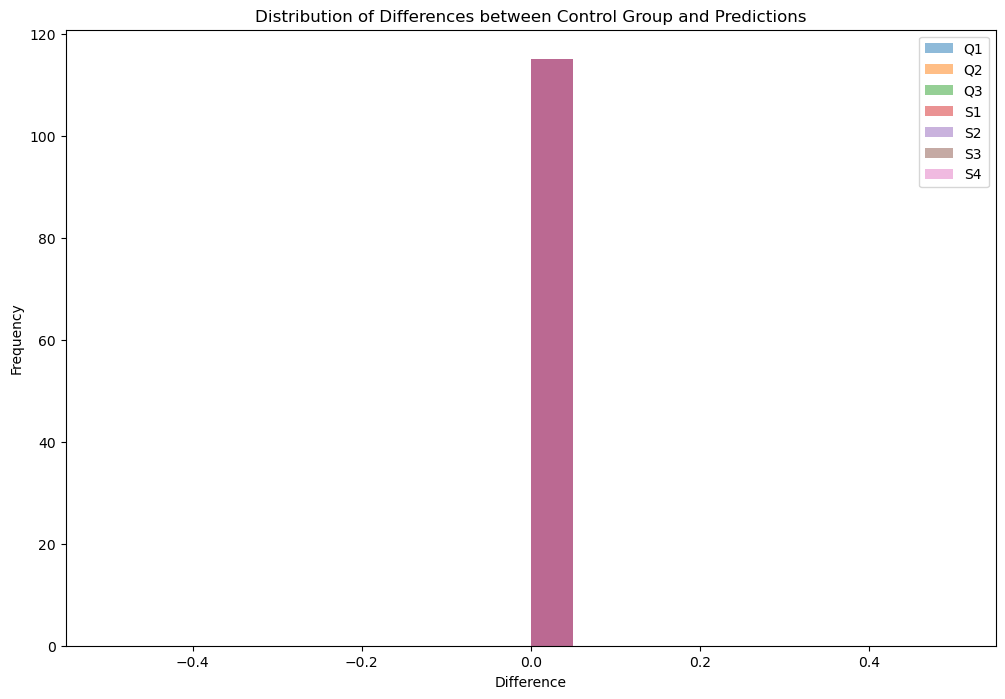

In [24]:
# Merge the two dataframes on common columns (e.g., 'subject_id' and 'date')
merged_df = pd.merge(real_test, predictions_df, on=['subject_id', 'date'], suffixes=('_control', '_pred'))

# Calculate the differences for each target variable
differences = {}
for target in targets:
    col_control = target + '_control'
    col_pred = target + '_pred'
    differences[target] = merged_df[col_control] - merged_df[col_pred]

# Create a DataFrame to show the differences
differences_df = pd.DataFrame(differences)

# Display the differences
print("Differences between control group and predictions:")
print(differences_df.describe())

# Alternatively, visualize the differences
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for target in targets:
    plt.hist(differences_df[target], bins=20, alpha=0.5, label=target)
plt.legend()
plt.title('Distribution of Differences between Control Group and Predictions')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

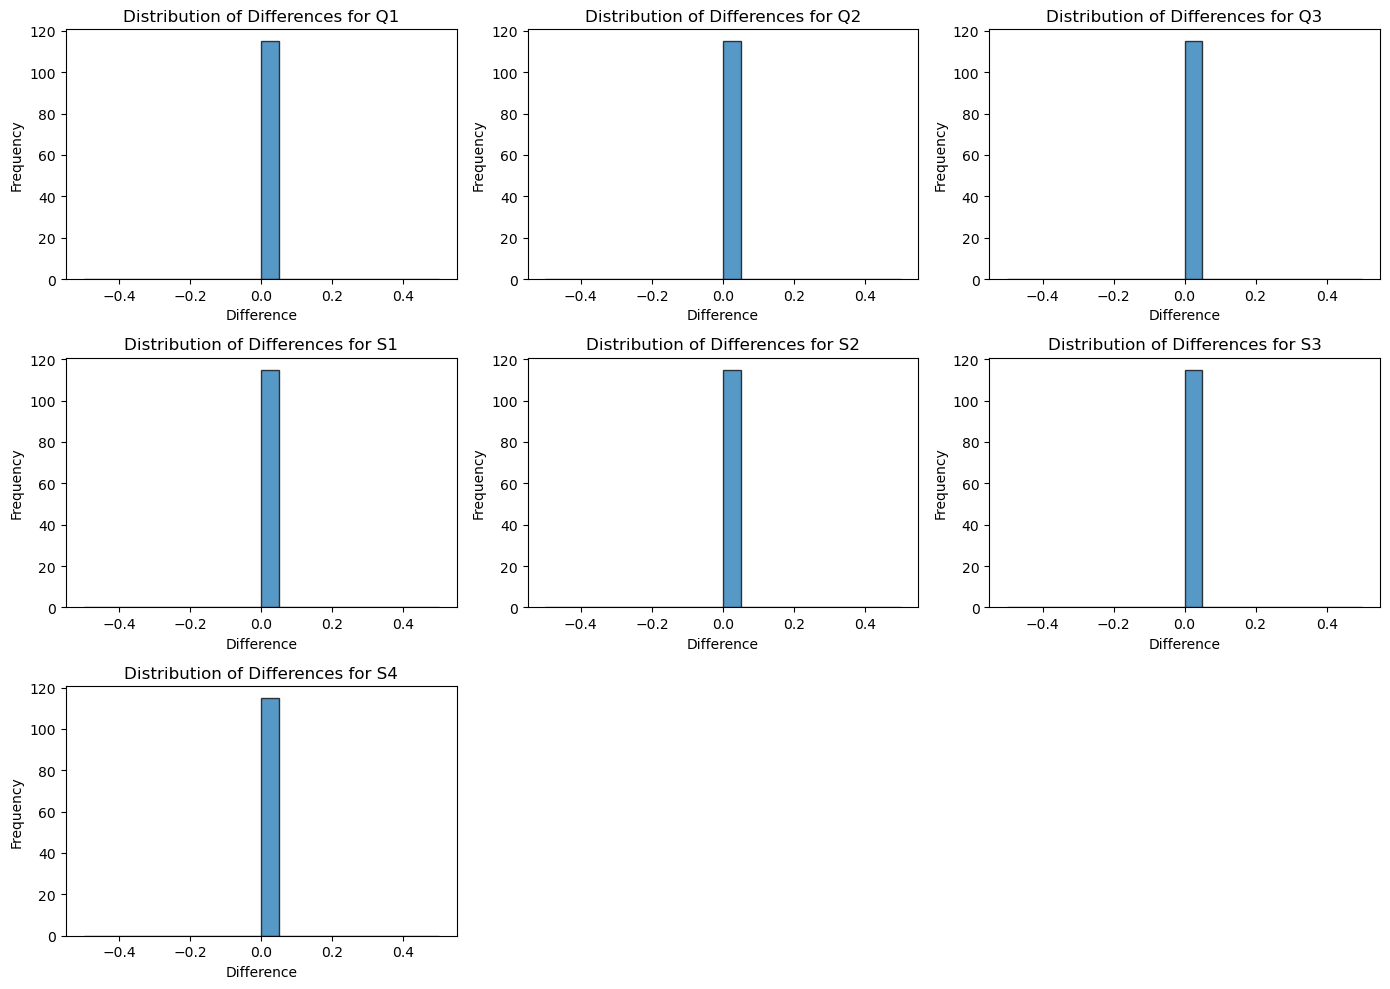

In [25]:
# Plotting the histogram of differences
plt.figure(figsize=(14, 10))

for idx, target in enumerate(targets, 1):
    plt.subplot(3, 3, idx)  # Adjust the layout to fit all subplots
    plt.hist(differences_df[target], bins=20, alpha=0.75, edgecolor='black')
    plt.title(f'Distribution of Differences for {target}')
    plt.xlabel('Difference')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()